<a href="https://colab.research.google.com/github/Guhan-10/Guhan-10/blob/main/SkinAlyze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import os
import shutil

# Load metadata
df = pd.read_csv('/content/drive/MyDrive/ai/HAM10000_metadata.csv')

# Define image folder (only part 1)
image_dir = '/content/drive/MyDrive/ai/HAM10000_images_part_1'

# Get available image IDs from part 1
available_images = {
    img.replace('.jpg', '') for img in os.listdir(image_dir) if img.endswith('.jpg')
}

# Filter dataframe to include only images from part 1
df_filtered = df[df['image_id'].isin(available_images)]

print("Filtered image count:", len(df_filtered))
print("Class distribution:\n", df_filtered['dx'].value_counts())

# Create destination folder
os.makedirs('class_data', exist_ok=True)

# Create class-specific folders
for label in df_filtered['dx'].unique():
    os.makedirs(f'class_data/{label}', exist_ok=True)

# Copy images into class folders
missing = 0
copied = 0
for _, row in df_filtered.iterrows():
    img_name = row['image_id'] + '.jpg'
    label = row['dx']
    src = os.path.join(image_dir, img_name)
    dst = os.path.join('class_data', label, img_name)

    if os.path.exists(src):
        shutil.copy(src, dst)
        copied += 1
    else:
        missing += 1

print(f"Images successfully copied: {copied}")
print(f"Missing images: {missing}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Filtered image count: 5000
Class distribution:
 dx
nv       3431
bkl       564
mel       435
bcc       266
akiec     183
vasc       65
df         56
Name: count, dtype: int64
Images successfully copied: 5000
Missing images: 0


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create train/validation generators
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    'class_data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    'class_data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 4002 images belonging to 7 classes.
Found 998 images belonging to 7 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(train_gen.num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,863 (42.61 MB)

 Trainable params: 11,169,863 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 346s 3s/step - accuracy: 0.6450 - loss: 1.3340 - val_accuracy: 0.6854 - val_loss: 0.9945
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 340s 3s/step - accuracy: 0.6906 - loss: 0.8942 - val_accuracy: 0.6934 - val_loss: 0.8653
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 341s 3s/step - accuracy: 0.6958 - loss: 0.8408 - val_accuracy: 0.7004 - val_loss: 0.8219
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 342s 3s/step - accuracy: 0.7277 - loss: 0.7535 - val_accuracy: 0.7084 - val_loss: 0.7901
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 339s 3s/step - accuracy: 0.7248 - loss: 0.7433 - val_accuracy: 0.7265 - val_loss: 0.7723
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 339s 3s/step - accuracy: 0.7364 - loss: 0.7002 - val_accuracy: 0.7204 - val_loss: 0.8331
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 340s 3s/step - accuracy: 0.7722 - loss: 0.6328 - val_accuracy: 0.7275 - val_loss: 0.7516
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 341s 3s/step - accuracy: 0.7978 - loss: 0.5381 - val_accu

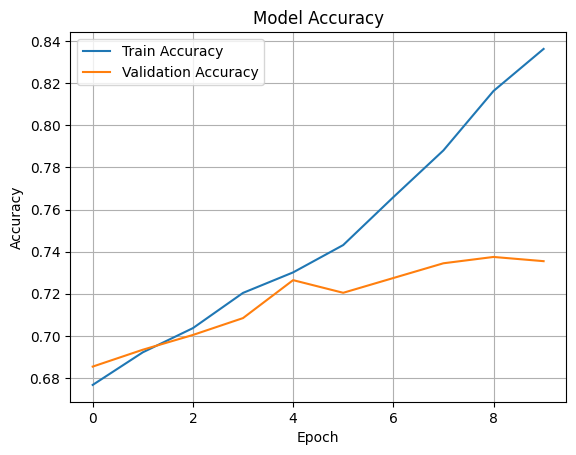

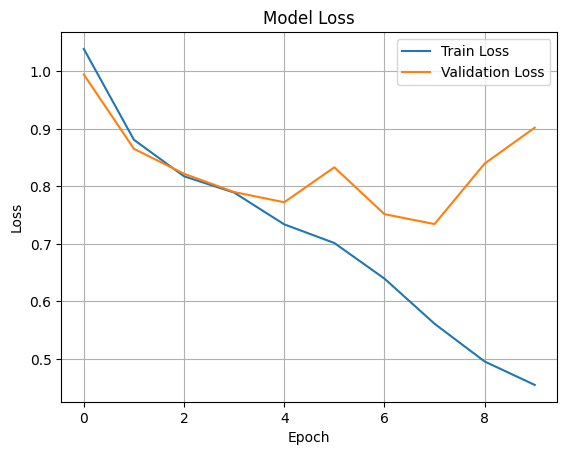

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
val_loss, val_accuracy = model.evaluate(val_gen)
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")


32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 678ms/step - accuracy: 0.7519 - loss: 0.8757
Validation Accuracy: 73.55%


32/32 ━━━━━━━━━━━━━━━━━━━━ 22s 669ms/step


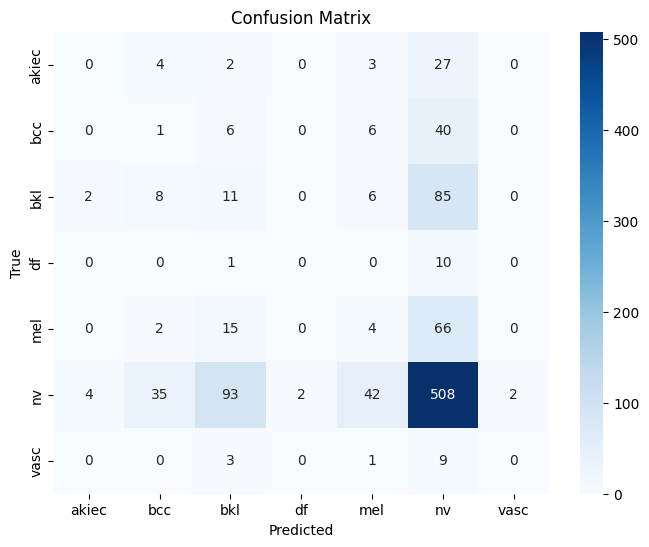

              precision    recall  f1-score   support

       akiec       0.00      0.00      0.00        36
         bcc       0.02      0.02      0.02        53
         bkl       0.08      0.10      0.09       112
          df       0.00      0.00      0.00        11
         mel       0.06      0.05      0.05        87
          nv       0.68      0.74      0.71       686
        vasc       0.00      0.00      0.00        13

    accuracy                           0.53       998
   macro avg       0.12      0.13      0.12       998
weighted avg       0.48      0.53      0.50       998



In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get true labels and predictions
y_true = val_gen.classes
y_pred = model.predict(val_gen)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
labels = list(val_gen.class_indices.keys())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred_classes, target_names=labels))


In [ ]:
model.save("skin_cancer_model.h5")

# Download the model
from google.colab import files
files.download("skin_cancer_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Mapping of class codes to full names
label_names = {
    'nv': 'Melanocytic nevus (mole)',
    'mel': 'Melanoma (skin cancer)',
    'bkl': 'Benign keratosis-like lesion',
    'bcc': 'Basal cell carcinoma (skin cancer)',
    'akiec': 'Actinic keratosis / Bowen’s disease',
    'vasc': 'Vascular lesion',
    'df': 'Dermatofibroma'
}


Saving ISIC_0024357.jpg to ISIC_0024357.jpg

Processing file: ISIC_0024357.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


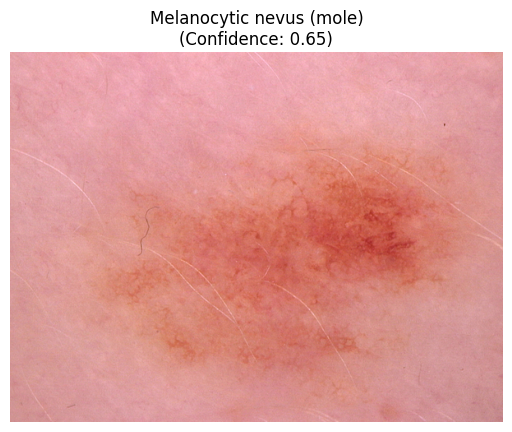

Predicted Type: Melanocytic nevus (mole)
Confidence: 0.65


In [19]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np

from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Class labels from the training generator
class_labels = list(train_gen.class_indices.keys())

# Prediction with full name
def predict_uploaded_image():
    uploaded = files.upload()

    for file_name in uploaded.keys():
        print(f"\nProcessing file: {file_name}")

        # Load and preprocess image
        img = image.load_img(file_name, target_size=(224, 224))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Predict
        prediction = model.predict(img_array)
        predicted_class = class_labels[np.argmax(prediction)]
        confidence = np.max(prediction)

        # Get full name
        full_name = label_names[predicted_class]

        # Show result
        plt.imshow(image.load_img(file_name))
        plt.axis('off')
        plt.title(f"{full_name}\n(Confidence: {confidence:.2f})")
        plt.show()

        print(f"Predicted Type: {full_name}")
        print(f"Confidence: {confidence:.2f}")


# Call the function
predict_uploaded_image()
